```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate power consumption for
different block sizes for selected numerical schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Power consumption: Block Size Experiment

This notebook runs some iterations of each of different numerical schemes on a range of different CUDA block sizes.
The 'nvidia-smi' application runs in the background and records various parameters, such as GPU power consumption, core temperature, etc, and reports these parameters to a log file. 
The performance is simultaneously reported in a text file.
These parameters are later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the power consumption results.

### To find your own power consumption
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import socket
import os.path
import time
from tempfile import TemporaryFile


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
    
    
#Use the existing file, do not generate new data
#folder_name = os.path.abspath("power_block_size_0")

print("Storing data in folder " + folder_name)
main_log_filename='power_consumptions.log'

Storing data in folder /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_15


In [3]:
# Specify python command:
#python = "python"

python = 'python3'
if socket.gethostname().startswith('havahol'):
    python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"
shell = False
print(python)

/home/havahol/miniconda3/envs/gpuocean/bin/python


In [4]:
# benchmark duration parameter
steps_per_iteration_benchmark = 100

# nvidia-smi parameters:
smi_loop_ms = 50
sleep_duration_sec = 3

# derived parameters:
smi_entries_per_sec = round(1000/smi_loop_ms) # Number of smi log entries per second
num_entries_to_ignore = smi_entries_per_sec*sleep_duration_sec 



In [5]:
def runBenchmark(folder_name):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    sim = np.array(["CDKLM"])
    #block_width = np.array([4, 8, 12, 16, 24, 32])
    #block_height = np.array([4, 8, 12, 16, 24, 32])
    block_width = np.array([12, 16, 24])#, 8]), #12, 16, 24, 32])
    block_height = np.array([12, 16, 24])#, 8]) #, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print('Sims: ' + str(sim))
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    test_filename = os.path.join(folder_name, main_log_filename)
    
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")

            
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    

                    start_info = sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j])
                    test_file.write("=========================================\n")
                    test_file.write(start_info)
                    test_file.write("-----------------------------------------\n")
                    print('\n'+start_info)
                    
                    with TemporaryFile() as tmpfile:

                        # Start nvidia-smi to file f
                        smi_report_filename = 'nvidia_smi_w'+str(block_width[i,j])+'_h'+str(block_height[i,j])+'.log'
                        smi_report_file = os.path.join(folder_name, smi_report_filename)

                        print('')
                        smi_cmd = [
                            'nvidia-smi',
                            '--query-gpu=timestamp,'+\
                                        'temperature.gpu,'+\
                                        'memory.free,'+\
                                        'fan.speed,'+\
                                        'utilization.gpu,'+\
                                        'power.draw,'+\
                                        'clocks.current.sm,'+\
                                        'clocks.current.graphics,'+\
                                        'clocks.current.memory',
                            '--format=csv',
                            '--loop-ms='+str(smi_loop_ms),
                            '--filename='+str(smi_report_file)
                        ]
                        test_file.write("=========================================\n")
                        test_file.write('nvidia_smi_file='+str(smi_report_file)+', ')
                        test_file.write('nvidia_smi_cmd='+str(smi_cmd)+', ')
                        print('nvidia_smi_file='+str(smi_report_file))

                        smi_process = subprocess.Popen(smi_cmd, shell=shell, 
                                                       stdin=subprocess.PIPE, 
                                                       stdout=tmpfile, 
                                                       stderr=subprocess.STDOUT)


                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Run benchmark
                        print('starting benchmark... ', end='')
                        tic = time.time()

                        cmd = [ python, "run_benchmark.py", 
                               "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                               "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                               "--steps_per_download", str(steps_per_iteration_benchmark), 
                               "--iterations", "10"]
                        p = subprocess.Popen(cmd, shell=shell, 
                                             stdin=subprocess.PIPE, 
                                             stdout=subprocess.PIPE, 
                                             stderr=subprocess.STDOUT)

                        # process output from run benchmark
                        output = p.stdout.read()
                        test_file.write(str(output) + "\n")
                        test_file.write("=========================================\n")
                        test_file.write("\n")
                        print('benchmark finished!')

                        toc = time.time()

                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Kill nvidia-smi process.
                        smi_process.terminate()
                    
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)

# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
            

#folder_name = os.path.abspath("power_block_size_14")
folder_name = os.path.abspath("amazon_v100/power_block_size_1/")
if not (os.path.isdir(folder_name)):
    os.mkdir(folder_name)
    runBenchmark(folder_name)
    print('Done!')
else:
    print("Using existing run in " + folder_name)

Using existing run in /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/amazon_v100/power_block_size_1


In [23]:
dataframe_columns = ['simulator', 'block_width', 'block_height', 
                     'megacells',
                     'max_temperature', 'min_temperature', 'cumsum_temperature',
                     'max_power', 'min_power', 'total_power', 'mean_power',
                     'max_utilization', 'min_utilization', 'mean_utilization',
                     'megacells_per_joule'
                     ]
labels = ['simulator', 'block_width', 'block_height', 
          'Megacells/s',
          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]',
          'Max power consumption [W]', 'Min power consumption [W]', 
          'Energy consumption [J]', 'Mean power consumption [W]',
          'Max GPU utilization [%]', 'Min GPU utilization [%]', 'Mean GPU utilization [%]',
          'Megacells per Joule'
         ]


def read_smi_file(smi_log_file):
    smi_log = pd.read_csv(smi_log_file)
    temp_key  = 'temperature.gpu'
    power_key = 'power.draw [W]'
    utilization_key = 'utilization.gpu [%]'
    fan_key = 'fan.speed [%]'
    
    # Remove whitespaces from column names:
    smi_log.rename(columns=lambda x: x.strip(), inplace=True)

    #for col in smi_log.columns:
    #    print(col)
        
    # Parse missing values
    smi_log = smi_log.replace(' [Not Supported]', np.NaN)
    
    # Helper function for parcing percent values
    def parse_value(df, key, unit):
        if not pd.isnull(df[key].iloc[0]):
            #print('fixing ' + key)
            df[key] = df[key].str.replace(' ','')
            df[key] = df[key].str.replace(unit, '')
            df[key] = pd.to_numeric(smi_log[key])
            
    parse_value(smi_log, utilization_key, '%')
    parse_value(smi_log, fan_key, '%')
    parse_value(smi_log, power_key, 'W')
    
    # Find min and max 
    max_temperature = smi_log[temp_key].max()
    min_temperature = smi_log[temp_key].min()
    min_power_draw  = smi_log[power_key].min()
    max_power_draw  = smi_log[power_key].max()
    min_utilization = smi_log[utilization_key].min()
    max_utilization = smi_log[utilization_key].max()
    
    # temperature*seconds
    all_sum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000

    # Drop first and last rows
    # This compensates for the sleep commands above.
    smi_log.drop(smi_log.head(num_entries_to_ignore).index,inplace=True)
    smi_log.drop(smi_log.tail(num_entries_to_ignore).index,inplace=True)
    
    cumsum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000
    
    total_power = (smi_log[power_key]-min_power_draw).sum()*smi_loop_ms/1000
    if np.isnan(max_power_draw) and np.isnan(min_power_draw):
        total_power = np.NaN
    mean_power = smi_log[power_key].mean()-min_power_draw
    mean_utilization = smi_log[utilization_key].mean()
    
    # All these experiements use the same number of iterations,
    # hence, relative megacells_per_joule = 1/total_power
    rel_megacells_per_joule = 1/total_power
    
    computed_megacells = 2048*2048*100*10e-6
    megacells_per_joule = computed_megacells/total_power
    
    
    ### TODO! Multiply with the appropriate number of megacells = nx*ny*steps_per_download*iterations
        
    df_values = {'max_temperature': max_temperature,
                 'min_temperature': min_temperature,
                 'cumsum_temperature': cumsum_temperature,
                 'max_power': max_power_draw,
                 'min_power': min_power_draw,
                 'total_power': total_power,
                 'mean_power': mean_power,
                 'max_utilization': max_utilization,
                 'min_utilization': min_utilization,
                 'mean_utilization': mean_utilization,
                 'megacells_per_joule': megacells_per_joule
                }
    
    return df_values


def getData(filename):
    # State variables
    simulator = None
    block_width = None
    megacells = None
    block_height = None
    #max_temperature = None
    #min_temperature = None
    #cumsum_temperature = None
    #power_draw = None
    
    
    df = pd.DataFrame(columns = dataframe_columns)
    
    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)
            
            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)
                
            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                
            # Find nvidia-smi report
            match = re.match('nvidia_smi_file=(.+).log,', line)
            if match:
                smi_log_file = os.path.abspath(match.group(1)+'.log')

                # In case the experiment was run on a different computer than this
                if not os.path.isfile(smi_log_file):
                    smi_log_filename = os.path.split(smi_log_file)[-1]
                    potential_folder = os.path.split(filename)[0]
                    smi_log_file = os.path.join(potential_folder, smi_log_filename)

                assert os.path.isfile(smi_log_file), 'Did not find smi_log_file ' +  str(smi_log_file)
           
                df_entries = {'simulator': simulator,
                              'block_width': block_width,
                              'block_height': block_height,
                              'megacells': megacells}
                
                df_smi_entries = read_smi_file(smi_log_file)
                df_entries.update(df_smi_entries)
                
                df = df.append(df_entries , ignore_index=True)
                
                
                
                
                block_width = None
                block_height = None
                #max_temperature = None 
                #min_temperature = None
                #cumsum_temperature = None
                megacells = None
                #simulator = None
            
    return df

main_log_file = os.path.join(folder_name, main_log_filename)
df = getData(main_log_file)
df


,simulator,block_width,block_height,megacells,max_temperature,min_temperature,cumsum_temperature,max_power,min_power,total_power,mean_power,max_utilization,min_utilization,mean_utilization,megacells_per_joule
0,CDKLM,04,04,2072.95045135,66,58,668.55,236.41,60.87,1712.7310,163.897703,100,0,94.784689,2.448898
1,CDKLM,04,08,3061.34124524,66,58,412.10,257.87,59.42,1163.7300,181.832812,100,0,91.656250,3.604190
2,CDKLM,04,12,3214.16717344,66,57,326.40,293.11,32.05,1210.1545,239.634554,100,0,90.405941,3.465924
3,CDKLM,04,16,3455.94542140,65,55,286.75,299.04,30.56,1077.4455,236.801209,100,0,88.208791,3.892822
4,CDKLM,04,24,3430.12038995,64,56,305.10,284.71,58.38,968.6435,197.682347,100,0,88.704082,4.330080
5,CDKLM,04,32,3550.54406879,65,56,317.75,277.48,58.38,963.7285,188.966373,100,0,88.882353,4.352163
6,CDKLM,08,04,3462.90495687,65,55,374.25,260.84,32.03,1227.1705,204.528417,100,0,90.208333,3.417866
7,CDKLM,08,08,3998.56434248,65,56,264.15,285.89,58.88,829.2410,197.438333,100,0,85.833333,5.058004
8,CDKLM,08,12,4081.44248707,65,57,266.70,276.99,58.92,780.1460,183.563765,100,0,85.635294,5.376306
9,CDKLM,08,16,4188.34009219,65,56,266.45,271.73,32.01,890.4555,209.518941,100,0,87.223529,4.710290


['04' '08' '12' '16' '24' '32']
Plotting megacells
         04       08       12       16       24       32
04  2072.95  3061.34  3214.17  3455.95  3430.12  3550.54
08  3462.91  3998.56  4081.44  4188.34  3795.96  3979.26
12  3383.82  4035.07  3766.51  3802.04  3596.77  3552.72
16  4148.41  4311.79  3895.85  4104.07   3640.4  3265.73
24  4083.08   3933.6  3702.97  3663.06  3381.36  2549.05
32  4433.96   4447.6  3950.71  3575.29  2770.86  3093.67
         04       08       12       16       24       32
04  2072.95  3061.34  3214.17  3455.95  3430.12  3550.54
08  3462.91  3998.56  4081.44  4188.34  3795.96  3979.26
12  3383.82  4035.07  3766.51  3802.04  3596.77  3552.72
16  4148.41  4311.79  3895.85  4104.07   3640.4  3265.73
24  4083.08   3933.6  3702.97  3663.06  3381.36  2549.05
32  4433.96   4447.6  3950.71  3575.29  2770.86  3093.67
Maximum=4447.60
Minimum=2072.95
Mean=3649.44
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/amazon_v100/power_block_s

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/amazon_v100/power_block_size_1/total_power_CDKLM.pdf
         04       08       12       16       24       32
04  1712.73  1163.73  1210.15  1077.45  968.643  963.729
08  1227.17  829.241  780.146  890.456  728.138  695.894
12  1077.81  853.729  737.078  688.406  761.904  765.182
16  783.875  696.742  758.198  764.495   675.32  637.462
24   889.31  782.042  599.647  621.153  719.696  770.474
32  741.666  602.149  648.591  685.076  572.711  533.645
         04       08       12       16       24       32
04  1712.73  1163.73  1210.15  1077.45  968.643  963.729
08  1227.17  829.241  780.146  890.456  728.138  695.894
12  1077.81  853.729  737.078  688.406  761.904  765.182
16  783.875  696.742  758.198  764.495   675.32  637.462
24   889.31  782.042  599.647  621.153  719.696  770.474
32  741.666  602.149  648.591  685.076  572.711  533.645
Maximum=1712.73
Minimum=533.65
Mean=822.61
/home/havahol/playground/

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/amazon_v100/power_block_size_1/min_utilization_FBL.pdf
Plotting mean_utilization
         04       08       12       16       24       32
04  94.7847  91.6562  90.4059  88.2088  88.7041  88.8824
08  90.2083  85.8333  85.6353  87.2235  86.6322  86.2619
12  88.0938  84.1923  95.7143  95.9324  85.0864  86.4824
16  84.8481  87.2625  94.6316  86.6709  87.4286  87.1358
24  86.1795  86.9878  85.2436  85.6386  87.7283  89.6633
32  85.2078  86.5921    86.16  85.0933  88.1667     85.7
         04       08       12       16       24       32
04  94.7847  91.6562  90.4059  88.2088  88.7041  88.8824
08  90.2083  85.8333  85.6353  87.2235  86.6322  86.2619
12  88.0938  84.1923  95.7143  95.9324  85.0864  86.4824
16  84.8481  87.2625  94.6316  86.6709  87.4286  87.1358
24  86.1795  86.9878  85.2436  85.6386  87.7283  89.6633
32  85.2078  86.5921    86.16  85.0933  88.1667     85.7
Maximum=95.93
Minimum=84.19
Mean=87.95
/

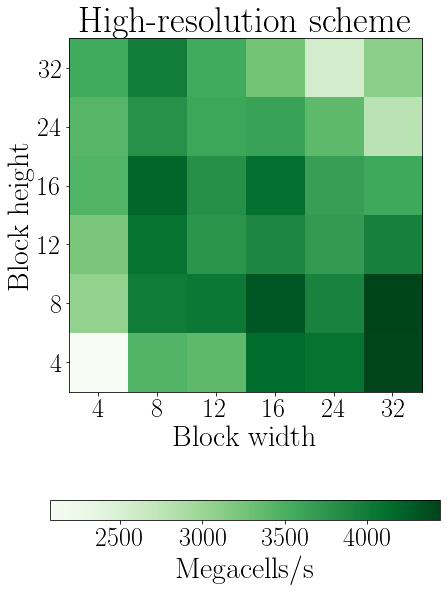

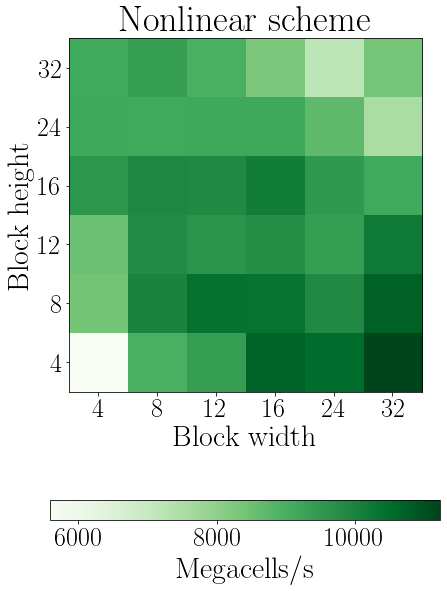

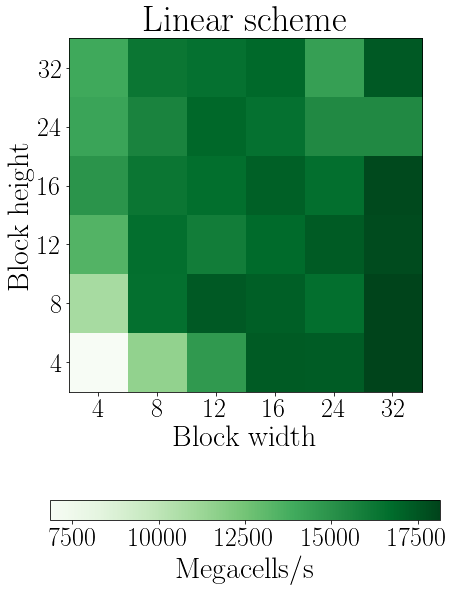

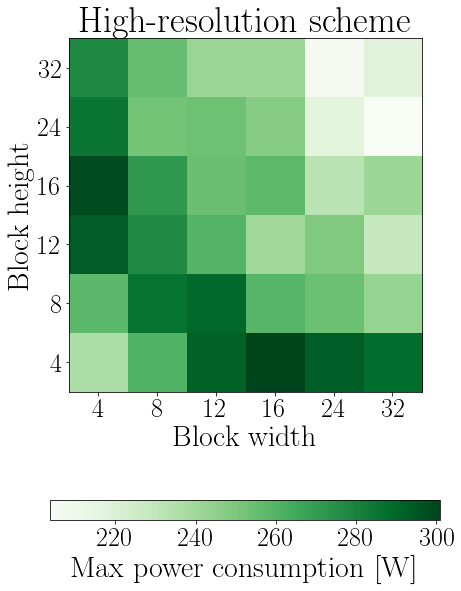

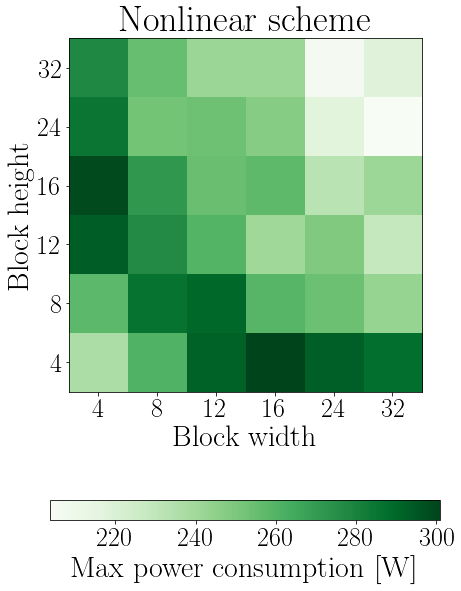

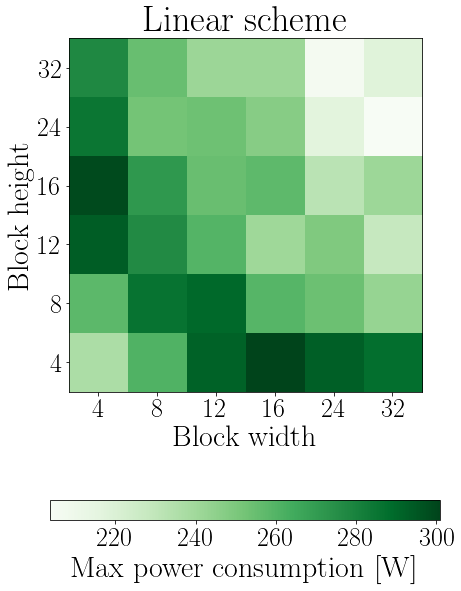

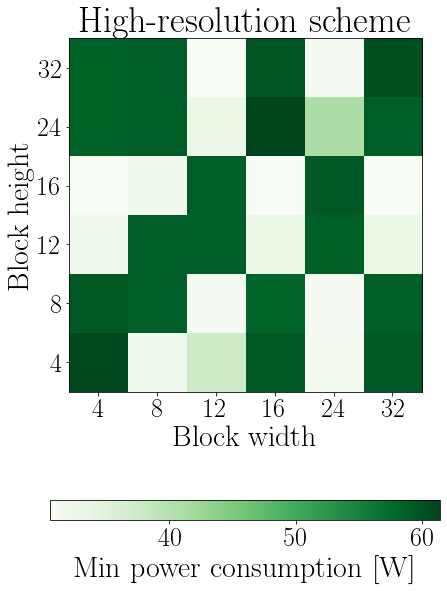

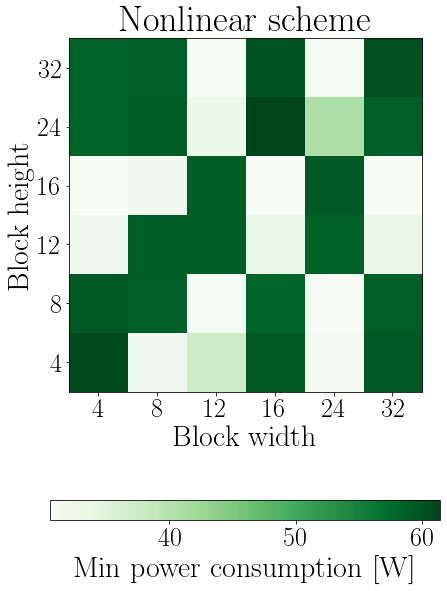

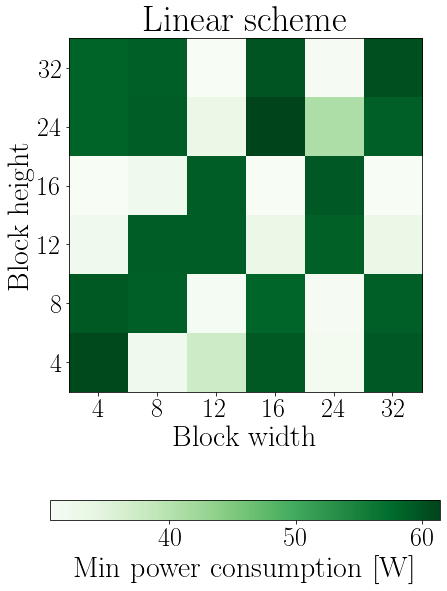

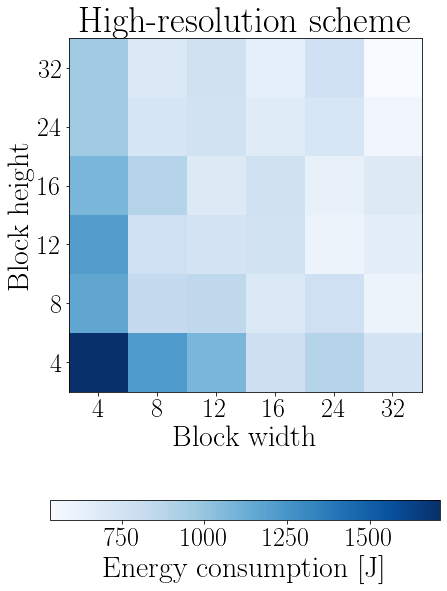

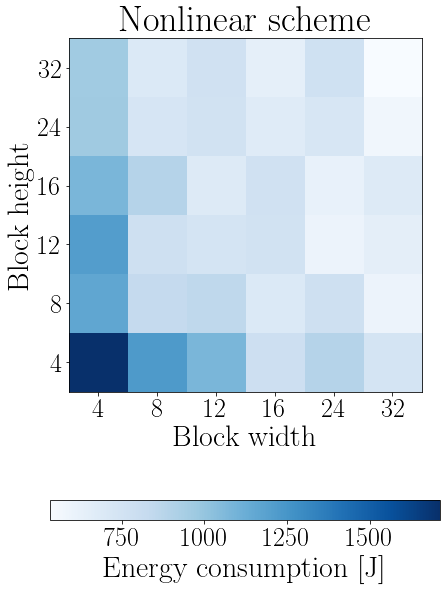

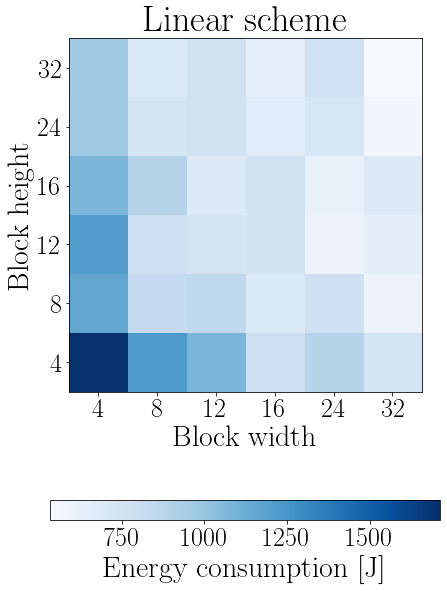

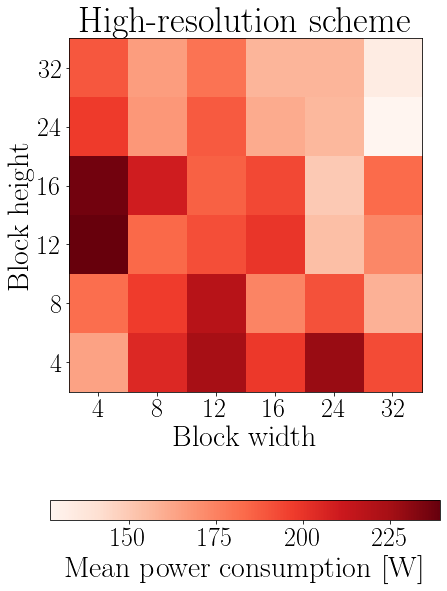

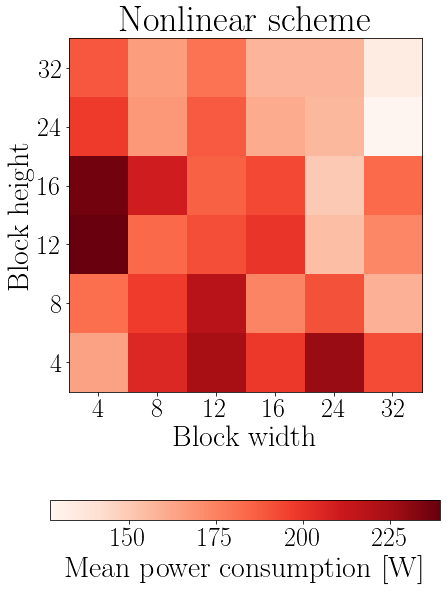

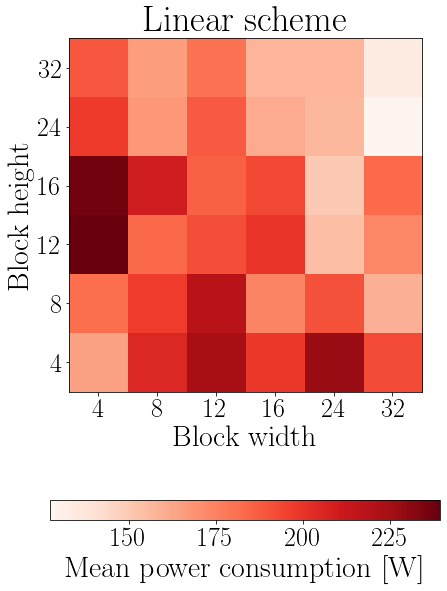

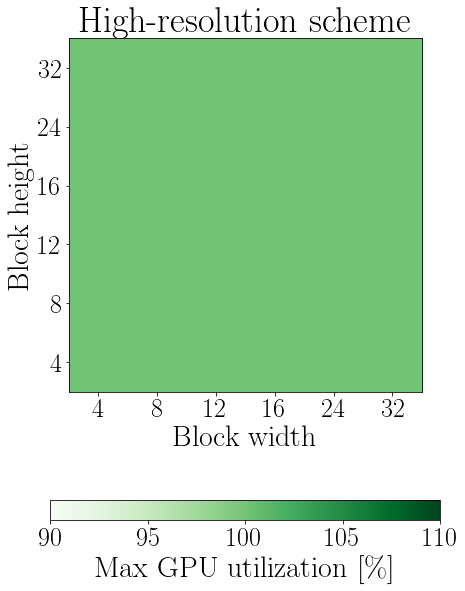

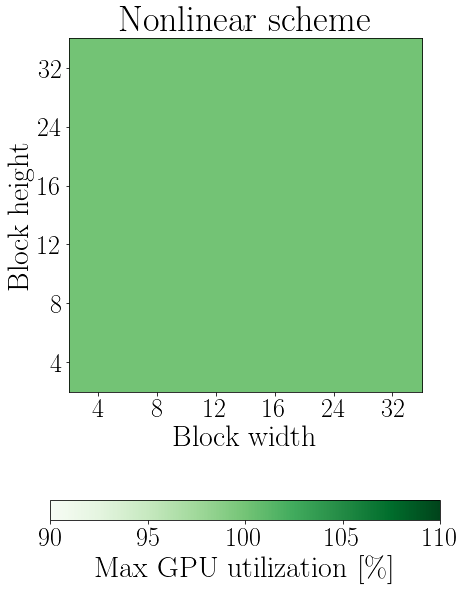

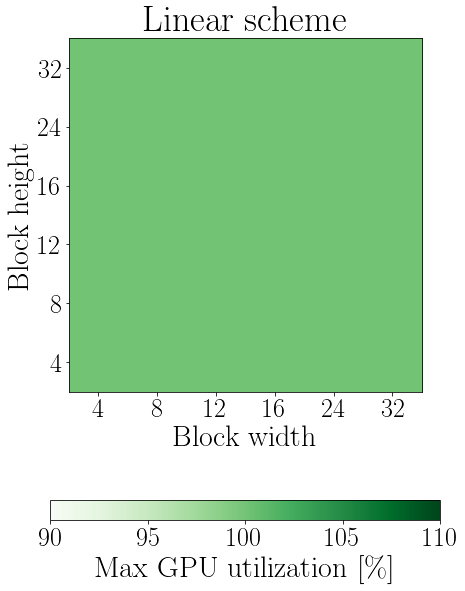

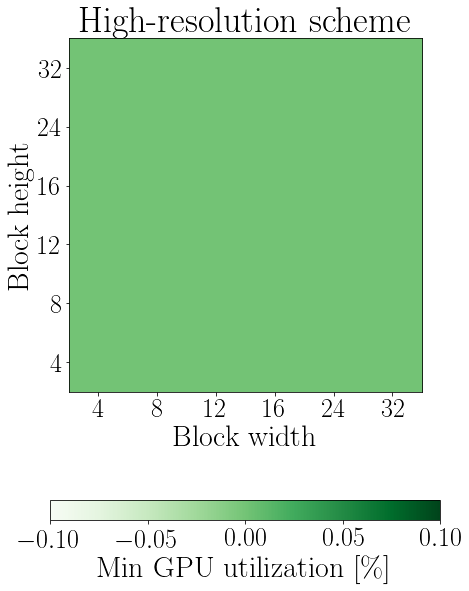

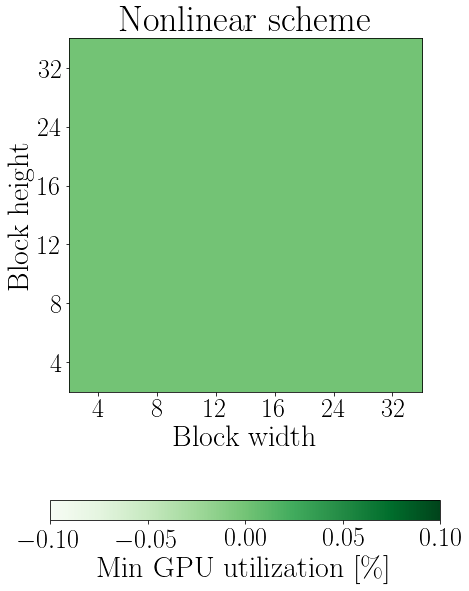

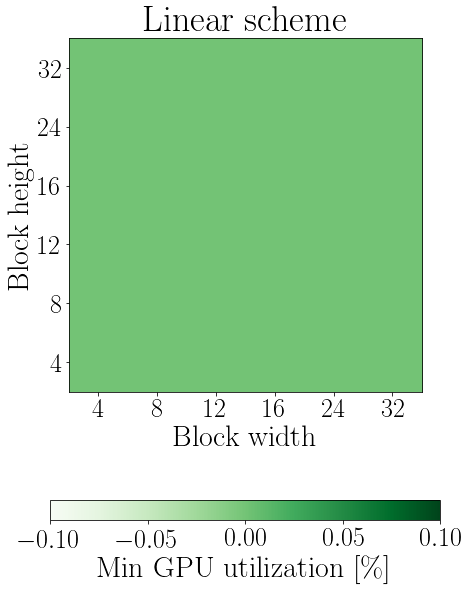

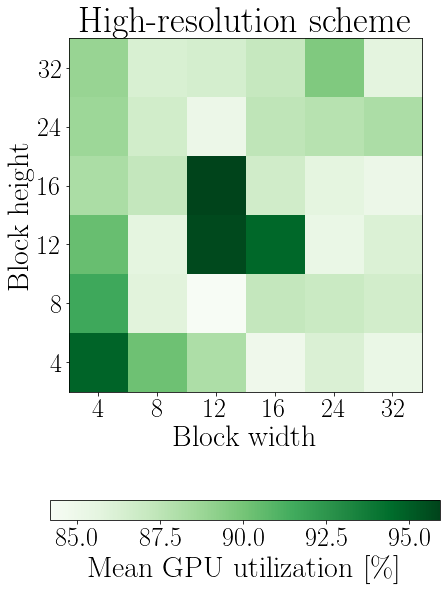

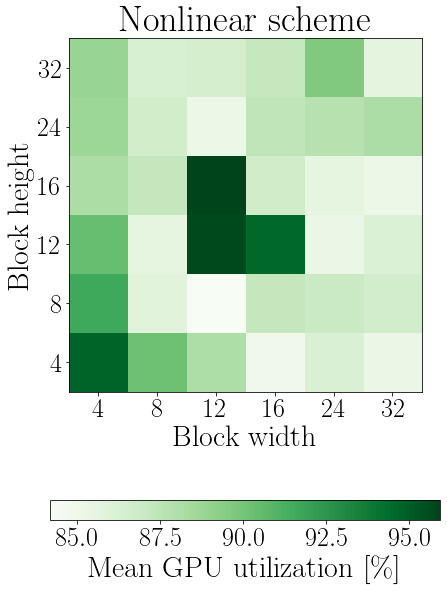

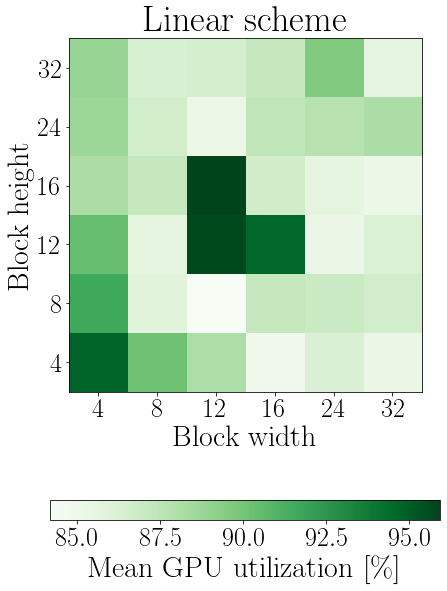

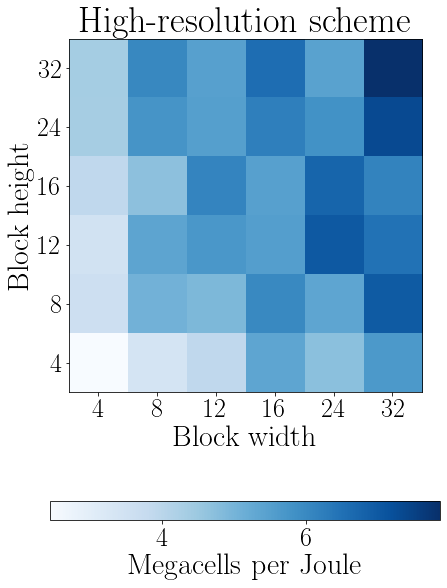

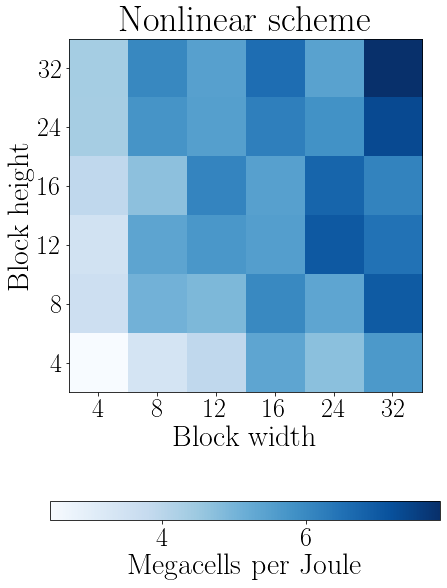

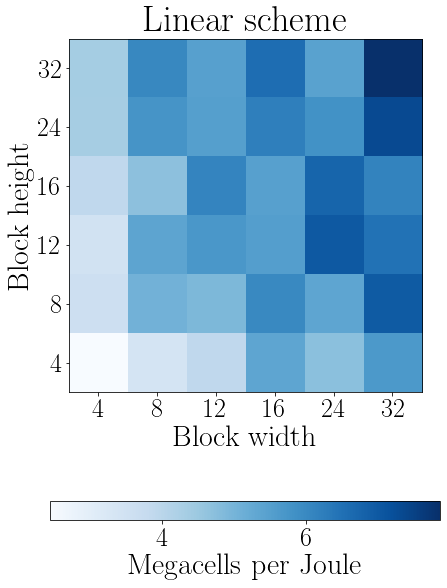

In [26]:
simulators = np.unique(df['simulator'])
block_widths = np.unique(df['block_width'])
block_heights = np.unique(df['block_width'])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#fields = ['simulator', 
#          'block_width', 'block_height', 'megacells',
#          'max_temperature', 'min_temperature', 'cumsum_temperature']
#          
#labels = ['simulator', 
#          'block_width', 'block_height', 'Megacells/s',
#          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]']


def plot_result(all_df, field_id, colorbar_on_the_side=False):
    
    assert(field_id > 2), 'field_id must take values between 3 and '+str(len(labels)-1)
    assert(field_id < len(labels)), 'field_id must take values between 3 and '+str(len(labels)-1)
             
        
    if dataframe_columns[field_id] in ['max_temperature', 'min_temperature', 'cumsum_temperature']:
        print('Skipping plot of ' + str(dataframe_columns[field_id]))
        return 
        
    print('Plotting ' + str(dataframe_columns[field_id]))
    
    for simulator in simulators:
        
        data = all_df[['simulator', 
                       'block_width', 'block_height', 
                       dataframe_columns[field_id]]].to_numpy()
        
        df = pd.DataFrame(index=block_widths, columns=block_heights)
        
        # Pick this simulator data only and sort into a dataframe
        columns = data[:,0] == simulator
        all_nan = True
        for record in data[columns]:
            block_width = record[1]
            block_height = record[2]
            values = np.float32(record[3])
            df[block_height][block_width] = values
            if not np.isnan(values):
                all_nan = False
            
        print(df)
        if all_nan:
            print('All values are NaN - nothing to plot')
            return

        maximum = np.nanmax(df.values)
        minimum = np.nanmin(df.values)
        mean = np.nanmean(df.values)
        print(df)
        print("Maximum={:.2f}".format(maximum))
        print("Minimum={:.2f}".format(minimum))
        print("Mean={:.2f}".format(mean))

        # Plot dataframe
        x = df.index.values.astype(np.int)
        y = df.columns.values.astype(np.int)
        z = np.transpose(df.values.astype(np.float32))
        
        cmap = cm.Greens
        if dataframe_columns[field_id] == 'mean_power':
            cmap = cm.Reds
        elif dataframe_columns[field_id] in ['total_power', 'megacells_per_joule']:
            cmap = cm.Blues
        
        fontsize=30
        if colorbar_on_the_side:
            fontsize = 22
        fig = None
        if colorbar_on_the_side:
            fig = plt.figure(figsize=(7,5))
        else:
            fig = plt.figure(figsize=(7,10))        
        ax = fig.add_subplot(111)
        img = ax.imshow(z, origin='lower', cmap=cmap, interpolation="None")

        plt.xticks( range(len(x)), x, fontsize=fontsize-4)
        ax.set_xlabel('Block width', fontsize=fontsize)
        plt.yticks( range(len(y)), y, fontsize=fontsize-4)
        ax.set_ylabel('Block height', fontsize=fontsize)

        cb = None
        if colorbar_on_the_side:
            cb = plt.colorbar(img)
        else:
            cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
        cb.ax.tick_params(labelsize=fontsize-4)
        #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
        cb.set_label(labels[field_id].replace('%', '\%'), fontsize=fontsize)#, labelpad=-40, y=0.45)


        fig_filename = dataframe_columns[field_id]+'_'+simulator+'.pdf'
        fig_file = os.path.join(folder_name, fig_filename)
        #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
        
        title = 'Linear scheme'
        if simulator == 'CTCS':
            title = 'Nonlinear scheme'
        elif simulator == 'CDKLM':
            title = 'High-resolution scheme'
        
        plt.title(title, fontsize=fontsize+6)
        if colorbar_on_the_side:
            plt.tight_layout()
        fig.savefig(fig_file)
        print(fig_file)
            
for field_id in range(3,len(dataframe_columns)):
    plot_result(df, field_id) #, colorbar_on_the_side=True)

In [25]:
print(folder_name)

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/amazon_v100/power_block_size_1


In [ ]:
a1 = [1, 2,3]
a2 = [4,6,67]
a1+a2

In [ ]:
df_base_entries = {'simulator': 1,
                                   'block_width': 2,
                                   'block_height': 3,
                                   'megacells': 4}
df_base_entries.update({'something': 1234})
df_base_entries

In [ ]:
percent = ' 37 %'
percent = percent.replace(' ', '').replace('%', '')
int(percent)

In [ ]:
read_smi_file('/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/prototypes/scripts/fbl_cuda_git_versions_desktop_nvidia-smi-reports/nvidia_smi_2019_08_23-16_30_34_38ff9b268a84e3f4a0805c67041b336f396e9a31.log')
pd.__version__